In [1]:
import pydrake.solvers.mathematicalprogram as mp
import numpy as np

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from polynomial import Polynomial
from piecewise import Piecewise

In [3]:
def piecewise_polynomial_variable(prog, domain, dimension, degree, kind="continuous"):
    if kind == "continuous":
        C = [prog.NewContinuousVariables(degree + 1, len(domain) - 1) for _ in range(dimension)]
    elif kind == "binary":
        C = [prog.NewBinaryVariables(degree + 1, len(domain) - 1) for _ in range(dimension)]
    else:
        raise ValueError("Expected kind to be 'continuous' or 'binary', but got {:s}".format(kind))    
    C = np.stack(C, axis=2)
    assert C.shape == (degree + 1, len(domain) - 1, dimension)
    return Piecewise(domain,
                     [Polynomial([C[i, j, :] for i in range(degree + 1)]) 
                          for j in range(len(domain) - 1)])

In [4]:
def require_continuity(prog, piecewise):
    for t in piecewise.breaks[1:-1]:
        frombelow = piecewise.from_below(t)
        fromabove = piecewise.from_above(t)
        for i in range(frombelow.size):
            prog.AddLinearConstraint(frombelow.flat[i].Expand() == fromabove.flat[i].Expand())
    

In [29]:
dt = 0.1
time_horizon = 1
ts = np.linspace(0, time_horizon, time_horizon / dt + 1)
dim = 1
mass = 1
g = 9.81
gravity_force = np.zeros(dim)
gravity_force[-1] = -mass * g

prog = mp.MathematicalProgram()
position = piecewise_polynomial_variable(prog, ts, dim, 2)
require_continuity(prog, position)
velocity = position.map(Polynomial.derivative)
require_continuity(prog, velocity)
acceleration = velocity.map(Polynomial.derivative)

contact_force = piecewise_polynomial_variable(prog, ts, dim, 0)
contact = piecewise_polynomial_variable(prog, ts, dim, 0, kind="binary")

# TODO: just one dimension handled here
for t in ts[:-1]:
    prog.AddLinearConstraint(contact_force(t)[0] <= 1000 * contact(t)[0])
    prog.AddLinearConstraint((position.from_below(t + dt)[0] - 10 * (1 - contact(t)[0])).Expand() <= 0)
    prog.AddLinearConstraint(position(t)[0] >= 0)

for t in ts[:-1]:
    for i in range(dim):
        prog.AddLinearConstraint(contact_force(t)[i] + gravity_force[i] == mass * acceleration(t)[i])

prog.AddLinearConstraint(position(0)[0] == 1.0)
prog.AddLinearConstraint(velocity(0)[0].Expand() == 0.0)

prog.AddQuadraticCost(np.eye(len(ts) - 1), np.zeros(len(ts) - 1), 
                      np.hstack([contact_force(t) for t in ts[:-1]]))

result = prog.Solve()
print(result)
assert result == mp.SolutionResult.kSolutionFound

q = position.map(lambda p: p.map(lambda x: prog.GetSolution(x)))

SolutionResult.kSolutionFound


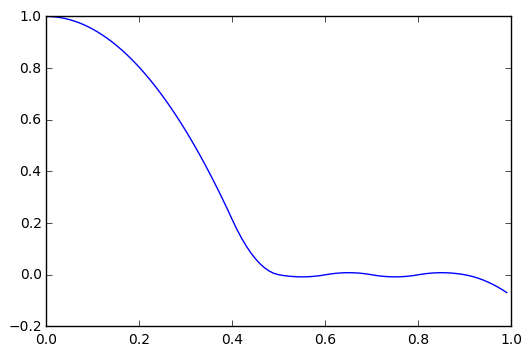

In [30]:
tt = np.linspace(ts[0], ts[-1] - 0.01, 100)
plot(tt, [q(t) for t in tt])